In [16]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd


In [17]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [18]:
batch_size = 128
n_mixture = 8
std = 0.025
radius = 1.0
latent_z_size =100
epochs = 2500

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

unroll_steps = 4

In [19]:
thetas = np.linspace(0, 2 * np.pi - 2 * np.pi / n_mixture, n_mixture)
centers = []
for i in range(0, len(thetas)):
    centers.append([radius * np.sin(thetas[i]), radius * np.cos(thetas[i])])
samples = []
for c in centers:
    samples.extend(np.random.normal(loc=c, scale=std, size=[8192, 2]).tolist())
#for s in range(len(samples)):
#    samples[s] = tf.convert_to_tensor(samples[s])
for z in range(len(samples)):
    samples[z] = [samples[z]]

#test output shape    
#o = np.array(samples)
#print(o.shape)
    
random.shuffle(samples)
samples = np.asarray(samples)
print(samples)
#print(samples.T[0:3])
train_data = mx.io.NDArrayIter(data = samples, batch_size = batch_size)

[[[ 0.68495817  0.68536092]]

 [[-0.6690533  -0.72409993]]

 [[-0.00530819  1.00211231]]

 ...

 [[-0.96160228 -0.01507255]]

 [[ 0.70045044 -0.70302841]]

 [[ 0.72162359 -0.72592756]]]


65536
1
2


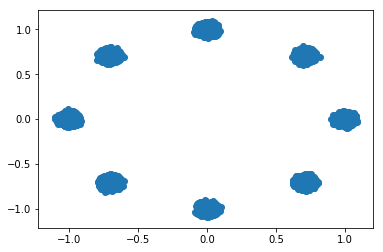

In [20]:
print(len(samples))
print(len(samples[0]))
print(len(samples[0][0]))

x= samples.T[0][0]
y = samples.T[1][0]
plt.scatter(x,y)

In [21]:
netG = nn.Sequential()
with netG.name_scope():
    #initially 128 x 100 x 2
    netG.add(nn.Conv1DTranspose(50, 4, in_channels = 100, padding = 2, strides =2))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # should now be 128 x 50 x 2
    netG.add(nn.Conv1DTranspose(25, 4, in_channels = 50, padding = 2, strides =2))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # should still be 128 x 25 x 2
    netG.add(nn.Conv1DTranspose(5, 4, in_channels = 25, padding = 2, strides =2))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    #should still be 128 x 5 x 2
    netG.add(nn.Conv1DTranspose(2, 4,  in_channels = 5, padding = 2, strides =2))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    #should still be 128 x 2 x 2
    netG.add(nn.Conv1DTranspose(1, 4,  in_channels = 2, padding = 2, strides =2))
    netG.add(nn.LeakyReLU(0.2))
    #should still be 128 x 1 x 2
    

In [22]:
netD = nn.Sequential()
with netD.name_scope():
    #input is 256 x 1 x 2
    netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
    netD.add(nn.LeakyReLU(0.2))
    # should still be 256 x 1 x 2
    netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # should still be 256 x 1 x 2
    netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # should still be 256 x 1 x 2
    netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # should still be 256 x 1 x 2
    
    
    
    netD.add(nn.Conv1D(channels = 1, kernel_size = 5, strides =2,padding = 2, in_channels = 1))
    # should still be 256 x 1 x 1

In [23]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.02), ctx = ctx)
netD.initialize(mx.init.Normal(0.02), ctx = ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
unrolledtrainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})


Done setting up Discriminator


INFO:root:
binary training acc at epoch 0: facc=0.500000
INFO:root:time: 9.620948
INFO:root:time: 9.629978


epoch 0
X: 
[-0.55903286]
<NDArray 1 @cpu(0)>   Y: 
[-0.22463512]
<NDArray 1 @cpu(0)>  
Plot


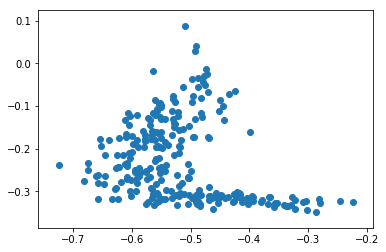

In [ ]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size * 2,), ctx = ctx)
fake_label = nd.zeros((batch_size * 2,), ctx = ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred>0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)


stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)


#set up Discriminator first

for i in range(250):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    #print("RUNNING")
    for batch1, batch2 in pairwise(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], dim = 0)).as_in_context(ctx)
        
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            fake = mx.ndarray.concat(firstFake, secondFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])
    name, acc = metric.get()
    metric.reset()
    
print("Done setting up Discriminator")

for epoch in range(epochs):
    train_data.reset()
    tic = time.time()
    btic = time.time()
    iter = 0
    #print("RUNNING")
    for batch1, batch2 in pairwise(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], dim = 0)).as_in_context(ctx)
        
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            fake = mx.ndarray.concat(firstFake, secondFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake1 = netG(latent_z1)
            fake2 = netG(latent_z2)
            output = netD(mx.ndarray.concat(fake1, fake2, dim = 0)).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step((batch1.data[0] +batch2.data[0]).shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            #logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            #logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
            #         %(nd.mean(errD).asscalar(),
            #           nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    #logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    #logging.info('time: %f' % (time.time() - tic))

    #Visualize one generated image for each epoch
    fake_img = fake[0]
    #print(len(fake))
    #print(len(fake[0]))
    #print(len(fake[0][0]))
    #print(fake)
    
    
    #test small print
    #print("epoch %d" % (epoch))
    #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
    #x= fake.T[0][0].asnumpy().tolist()
    #y = fake.T[1][0].asnumpy().tolist()
    #print("Plot")
    #plt.scatter(x,y)
    #plt.show()
    
    
    
    
    #real print
    if(epoch%250 == 0):
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))
        logging.info('time: %f' % (time.time() - tic))
        print("epoch %d" % (epoch))
        print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
        x= fake.T[0][0].asnumpy().tolist()
        y = fake.T[1][0].asnumpy().tolist()
        print("Plot")
        plt.scatter(x,y)
        plt.show()
    
    # visualize(fake_img)
    # plt.show()
